In [75]:
import os
import numpy as np
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Set the path to your dataset
dataset_path = "PokemonData"

# Pre-processing transformations
transform = transforms.Compose([
    transforms.Resize((28, 28)),                 # Resize to 28x28
    transforms.RandomHorizontalFlip(),           # Random horizontal flip
    transforms.RandomRotation(15),              # Random rotation
    transforms.ToTensor(),                       # Convert to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))        # Normalize pixel values
])

# Load dataset using ImageFolder (structured with subfolders for each Pokémon class)
dataset = ImageFolder(root=dataset_path, transform=transform)

# Extract labels to perform stratified splits
labels = np.array([item[1] for item in dataset.samples])  # Class indices

# Split into training, validation, and test sets
train_indices, temp_indices = train_test_split(
    range(len(labels)), test_size=0.25, stratify=labels, random_state=42
)
val_indices, test_indices = train_test_split(
    temp_indices, test_size=0.5, stratify=labels[temp_indices], random_state=42
)

# Reduce the size of the splits to match the requirement
train_indices = train_indices[:200]  # 200 training samples
val_indices = val_indices[:100]       # 100 validation samples
test_indices = test_indices[:50]     # 50 test samples

# Create subsets
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

# Create DataLoaders for each split
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Encode labels to numerical values
label_encoder = LabelEncoder()
labels = dataset.classes  # List of Pokémon classes
encoded_labels = label_encoder.fit_transform(labels)

# Summary of splits
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")



Training samples: 200
Validation samples: 100
Test samples: 50


In [77]:
import pennylane as qml
import torch.nn as nn

# Define the number of qubits (e.g., 4 for simplicity)
n_qubits = 9
dev = qml.device("default.qubit", wires=n_qubits)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the quantum circuit (encoding + convolutional layer)
@qml.qnode(dev, interface='torch')
def quantum_circuit(inputs):
    # Encoding: Use rotation gates based on input data
    for i in range(n_qubits):
        qml.RX(inputs[i], wires=i)

    # Random Quantum Circuit 
    for _ in range(2):  # Increase the depth by repeating
        for i in range(n_qubits):
            qml.RY(np.random.rand() * np.pi, wires=i)  # Random rotations
        for i in range(n_qubits - 1):
            qml.CNOT(wires=[i, i + 1])

    # Measure the expectation values of each qubit
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]
    

# Quantum layer in PyTorch
class QuantumLayer(nn.Module):
    def __init__(self):
        super(QuantumLayer, self).__init__()
        # Define quantum circuit using Pennylane
        self.qnode = qml.QNode(quantum_circuit, dev, interface="torch")

    def forward(self, x):
        # Ensure input features match the number of qubits
        assert x.shape[1] == n_qubits, "Input features must match the number of qubits"
        
        # Apply the quantum circuit to each data sample
        quantum_outputs = []
        for sample in x:
            # Convert the sample to a NumPy array if necessary
            sample_numpy = sample.detach().cpu().numpy()
            # Evaluate the QNode and convert the result back to a PyTorch tensor
            output = torch.tensor(self.qnode(sample_numpy), dtype=torch.float32, device=x.device)
            quantum_outputs.append(output)

        # Stack the results into a tensor
        return torch.stack(quantum_outputs)



In [21]:
pip install qiskit

  Using cached qiskit-1.2.4-cp38-abi3-win_amd64.whl.metadata (13 kB)
  Using cached dill-0.3.9-py3-none-any.whl.metadata (10 kB)
  Using cached symengine-0.13.0-cp39-cp39-win_amd64.whl.metadata (1.2 kB)
  Using cached pbr-6.1.0-py2.py3-none-any.whl.metadata (3.4 kB)
Using cached qiskit-1.2.4-cp38-abi3-win_amd64.whl (4.6 MB)
Using cached dill-0.3.9-py3-none-any.whl (119 kB)
   ---------------------------------------- 0.0/17.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/17.8 MB ? eta -:--:--
    --------------------------------------- 0.3/17.8 MB ? eta -:--:--
   - -------------------------------------- 0.8/17.8 MB 2.1 MB/s eta 0:00:09
   -- ------------------------------------- 1.0/17.8 MB 1.9 MB/s eta 0:00:09
   -- ------------------------------------- 1.3/17.8 MB 1.7 MB/s eta 0:00:10
   --- ------------------------------------ 1.6/17.8 MB 1.6 MB/s eta 0:00:11
   ---- ----------------------------------- 1.8/17.8 MB 1.4 MB/s eta 0:00:12
   ---- ---------------------

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\seher\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip


In [79]:
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector

class QuantumCNN(nn.Module):
    def __init__(self):
        super(QuantumCNN, self).__init__()
        # Classical Convolutional Layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)  # 32 filters
        self.pool1 = nn.MaxPool2d(2, 2)  # Downsample

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  # 64 filters
        self.pool2 = nn.MaxPool2d(2, 2)  # Downsample

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)  # 128 filters
        self.pool3 = nn.MaxPool2d(2, 2)  # Downsample
        
        # Fully connected to reduce to `n_qubits`
        self.reduce_to_qubits = nn.Linear(128 * 3 * 3, n_qubits)  # Adjust input size

        # Quantum layer
        self.quantum_layer = QuantumLayer()

        # Classification layer
        self.fc_output = nn.Linear(n_qubits, 151)

    def forward(self, x):
        # Classical Convolutional Layers
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))

        # Flatten the output
        x = x.view(-1, 128 * 3 * 3)
        print(f"Shape before quantum layer: {x.shape}")
        
        # Fully Connected Layer before Quantum Layer
        x = F.relu(self.reduce_to_qubits(x))

        # Quantum Layer
        x = self.quantum_layer(x)
        print(f"Shape after quantum layer: {x.shape}")

        # Fully connected classification layer
        x = torch.softmax(self.fc_output(x), dim=1)
        return x


# Initialize the model
model = QuantumCNN().to(device)
inputs = torch.rand(32, n_qubits).to(device)  # Random tensor of size n_qubits
quantum_output = quantum_circuit(inputs)
print(f"Quantum circuit output shape: {len(quantum_output)}")

for inputs, labels in train_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    print(f"Output shape: {outputs.shape}")
    break


Quantum circuit output shape: 9
Shape before quantum layer: torch.Size([32, 1152])
Shape after quantum layer: torch.Size([32, 9])
Output shape: torch.Size([32, 151])


In [17]:
pip install pylatexenc

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136867 sha256=cea705594dc64294c6a298697a3c97c6a8e9c58dfb29dabb52e1c8f4f189e00f
  Stored in directory: c:\users\seher\appdata\local\pip\cache\wheels\a3\68\66\2f15abd0673d83c02f354115feedeb89c3daed2ac319b11090
Successfully built pylatexenc
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\seher\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip


In [81]:
import pennylane as qml
from pennylane import numpy as np
from qiskit.circuit import ParameterVector
from qiskit import QuantumCircuit
from qiskit.circuit.library import ZZFeatureMap
import matplotlib.pyplot as plt

# Example of using the Pennylane's drawing tool
inputs = np.random.rand(n_qubits)
print(qml.draw(quantum_circuit)(inputs))  # Pennylane visualization

# Define a Qiskit circuit for visualization
params = ParameterVector("θ", length=n_qubits)
qiskit_circuit = QuantumCircuit(n_qubits)

# Add parameterized RX gates
for i in range(n_qubits):
    qiskit_circuit.rx(params[i], i)

# Add CNOT gates
for i in range(n_qubits - 1):
    qiskit_circuit.cx(i, i + 1)

# Draw the Qiskit circuit
qiskit_circuit.draw("mpl", style="Clifford")
plt.show()


0: ──RX(0.40)──RY(0.68)─╭●──RY(0.42)───────────╭●───────────────────────────────────────────────
1: ──RX(0.22)──RY(1.36)─╰X─╭●─────────RY(1.35)─╰X────────╭●─────────────────────────────────────
2: ──RX(0.43)──RY(1.51)────╰X────────╭●─────────RY(2.37)─╰X────────╭●───────────────────────────
3: ──RX(0.96)──RY(2.04)──────────────╰X────────╭●─────────RY(2.02)─╰X────────╭●─────────────────
4: ──RX(0.11)──RY(2.46)────────────────────────╰X────────╭●─────────RY(1.86)─╰X────────╭●───────
5: ──RX(0.11)──RY(0.50)──────────────────────────────────╰X────────╭●─────────RY(0.98)─╰X───────
6: ──RX(0.45)──RY(0.14)────────────────────────────────────────────╰X────────╭●─────────RY(0.73)
7: ──RX(0.04)──RY(2.59)──────────────────────────────────────────────────────╰X────────╭●───────
8: ──RX(0.68)──RY(2.20)────────────────────────────────────────────────────────────────╰X───────

──────────────────┤  <Z>
──────────────────┤  <Z>
──────────────────┤  <Z>
──────────────────┤  <Z>
──────────────────┤  <Z>
─

Shape before quantum layer: torch.Size([32, 1152])
Shape after quantum layer: torch.Size([32, 9])
Shape before quantum layer: torch.Size([32, 1152])
Shape after quantum layer: torch.Size([32, 9])
Shape before quantum layer: torch.Size([32, 1152])
Shape after quantum layer: torch.Size([32, 9])
Shape before quantum layer: torch.Size([32, 1152])
Shape after quantum layer: torch.Size([32, 9])
Shape before quantum layer: torch.Size([32, 1152])
Shape after quantum layer: torch.Size([32, 9])
Shape before quantum layer: torch.Size([32, 1152])
Shape after quantum layer: torch.Size([32, 9])
Shape before quantum layer: torch.Size([8, 1152])
Shape after quantum layer: torch.Size([8, 9])
Shape before quantum layer: torch.Size([32, 1152])
Shape after quantum layer: torch.Size([32, 9])
Shape before quantum layer: torch.Size([32, 1152])
Shape after quantum layer: torch.Size([32, 9])
Shape before quantum layer: torch.Size([32, 1152])
Shape after quantum layer: torch.Size([32, 9])
Shape before quantum l

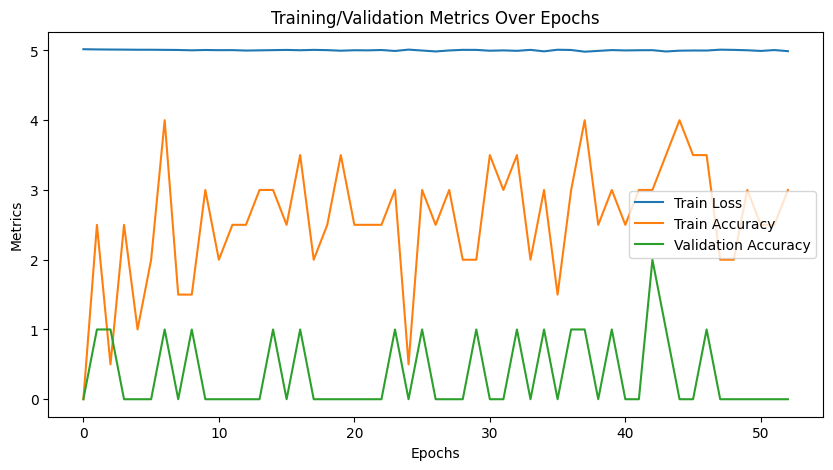

In [83]:
import torch.optim as optim
import matplotlib.pyplot as plt


# Send model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)
train_loss_values = []  # Store training loss values
train_accuracy_values = []  # Store training accuracy
val_accuracy_values = []  # Store validation accuracy

# Early stopping setup
patience = 10  # Number of epochs to wait before stopping
best_val_accuracy = 0
early_stop_counter = 0

# Training loop
num_epochs = 400
for epoch in range(num_epochs):
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for inputs, labels in train_loader:
        # Send data to device
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)
        
     # Calculate and store training metrics
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_loss_values.append(train_loss)
    train_accuracy_values.append(train_accuracy)

    # Validation phase
    model.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            # Send data to device
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model(val_inputs)
            _, val_predicted = torch.max(val_outputs, 1)
            correct_val += (val_predicted == val_labels).sum().item()
            total_val += val_labels.size(0)

    # Calculate and store validation accuracy
    val_accuracy = 100 * correct_val / total_val
    val_accuracy_values.append(val_accuracy)

    # Early stopping check
    if val_accuracy >= best_val_accuracy:
        best_val_accuracy = val_accuracy
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break
    # print(f'Epoch {epoch+1}, Loss: {epoch_loss}')
    # print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}')
# Plot training/validation metrics
plt.figure(figsize=(10, 5))
plt.plot(train_loss_values, label="Train Loss")
plt.plot(train_accuracy_values, label="Train Accuracy")
plt.plot(val_accuracy_values, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Metrics")
plt.legend()
plt.title("Training/Validation Metrics Over Epochs")
plt.show()


In [85]:

correct_test = 0
total_test = 0
all_test_labels = []
all_test_predictions = []

with torch.no_grad():
    for test_inputs, test_labels in test_loader:
        test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
        test_outputs = model(test_inputs)
        _, test_predicted = torch.max(test_outputs, 1)

        correct_test += (test_predicted == test_labels).sum().item()
        total_test += test_labels.size(0)
        all_test_labels.extend(test_labels.cpu().numpy())
        all_test_predictions.extend(test_predicted.cpu().numpy())

test_accuracy = 100 * correct_test / total_test
print(f"Test Accuracy: {test_accuracy:.2f}%")


Shape before quantum layer: torch.Size([32, 1152])
Shape after quantum layer: torch.Size([32, 9])
Shape before quantum layer: torch.Size([18, 1152])
Shape after quantum layer: torch.Size([18, 9])
Test Accuracy: 2.00%


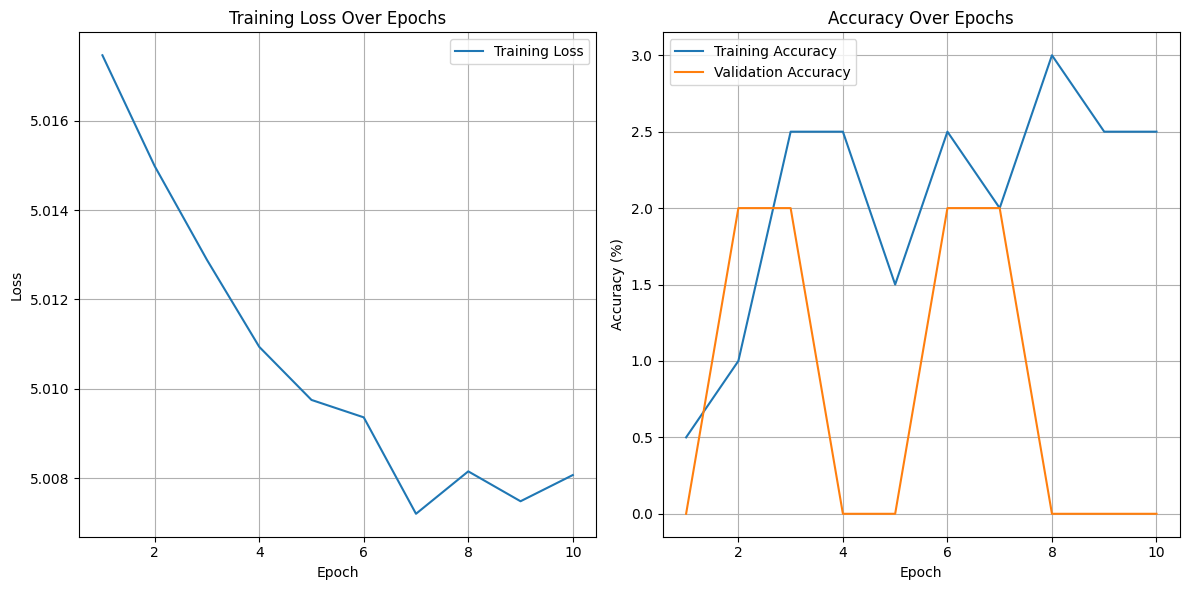

In [67]:
# Plot the training and validation metrics
plt.figure(figsize=(12, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_loss_values, marker='', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracy_values, marker='', label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracy_values, marker='', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [49]:
print(f"Number of classes: {len(set(labels))}")
for inputs, labels in train_loader:
    print(f"Batch labels: {labels}")
    break
print(f"Output layer size: {model.fc_output.out_features}")
max_label = max([max(labels.tolist()) for _, labels in train_loader])
print(f"Max label in dataset: {max_label}")

Number of classes: 8
Batch labels: tensor([  2,  79,  12,  75,  15,  82, 105,  90, 130,  47,  79, 128, 111, 108,
          0,   7,  44, 136, 108, 138, 119, 139,  43,  78, 115, 142,  97,  52,
         38,  32, 138, 108])
Output layer size: 150
Max label in dataset: 149


In [71]:
# Function to make predictions
from PIL import Image
def predict_pokemon(image_path):
    # Load and preprocess the input image
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)  # Add batch dimension
    
    # Perform prediction
    model.eval()
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
        pokemon_class = label_encoder.inverse_transform([predicted.item()])[0]
    
    # Output the class
    return pokemon_class

# Example usage
predicted_pokemon = predict_pokemon('pikachu.jpg')
print(f'Predicted Pokémon: {predicted_pokemon}')


Shape before quantum layer: torch.Size([1, 1152])
Shape after quantum layer: torch.Size([1, 9])
Predicted Pokémon: Pikachu


In [104]:
import tkinter as tk
from tkinter import filedialog
from PIL import Image
import torch
import torchvision.transforms as transforms

# Load the model and label encoder
# (Ensure these are properly defined and loaded in your main script)
# model = <your_trained_model>
# label_encoder = <your_label_encoder>

# Preprocessing pipeline
transform = transforms.Compose([
    transforms.Resize((28, 28)),          # Resize to 28x28 pixels
    transforms.ToTensor(),               # Convert to tensor
    transforms.Normalize((0.5,), (0.5,)) # Normalize to range [-1, 1]
])

# Function to predict Pokémon from an image
def predict_pokemon(image_path):
    try:
        # Load and preprocess the input image
        image = Image.open(image_path)  # Convert to grayscale
        image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device

        # Perform prediction
        model.eval()
        with torch.no_grad():
            output = model(image_tensor)
            _, predicted = torch.max(output, 1)
            pokemon_class = label_encoder.inverse_transform([predicted.item()])[0]

        # Output the class
        return pokemon_class
    except Exception as e:
        print(f"Error during prediction: {e}")
        return "Error"

# Function to open file picker dialog
def select_file():
    file_path = filedialog.askopenfilename(
        title="Select an Image",
        filetypes=[("Image files", "*.jpg *.jpeg *.png *.bmp")]
    )
    if file_path:
        print(f"Selected file: {file_path}")
        # Predict and display Pokémon name
        predicted_pokemon = predict_pokemon(file_path)
        print(f'Predicted Pokémon: {predicted_pokemon}')

# Create a simple GUI for file selection
def create_interface():
    root = tk.Tk()
    root.title("Pokémon Predictor")

    # Button to open file picker
    select_button = tk.Button(root, text="Select Image", command=select_file)
    select_button.pack(pady=20)

    # Label to provide instructions
    instructions = tk.Label(root, text="Click the button to select a Pokémon image.")
    instructions.pack(pady=10)

    root.mainloop()

# Run the interface
create_interface()


Selected file: C:/Users/seher/Downloads/jiggles.jpeg
Shape before quantum layer: torch.Size([1, 1152])
Shape after quantum layer: torch.Size([1, 9])
Predicted Pokémon: Kabuto
Selected file: C:/Users/seher/Downloads/aboror.png
Error during prediction: Given groups=1, weight of size [32, 3, 3, 3], expected input[1, 4, 28, 28] to have 3 channels, but got 4 channels instead
Predicted Pokémon: Error
Selected file: C:/Users/seher/Downloads/charms.jpg
Shape before quantum layer: torch.Size([1, 1152])
Shape after quantum layer: torch.Size([1, 9])
Predicted Pokémon: Kabuto


In [73]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch
import numpy as np

# Ensure your model is in evaluation mode
model.eval()

# Placeholder for predictions and true labels
all_predictions = []
all_true_labels = []

# Run inference on the test set
with torch.no_grad():
    for inputs, labels in test_loader:
        # Move data to device
        inputs, labels = inputs.to(device), labels.to(device)

        # Perform inference
        outputs = model(inputs)
        predicted = torch.argmax(outputs, dim=1)

        # Collect predictions and true labels
        all_predictions.extend(predicted.cpu().numpy())
        all_true_labels.extend(labels.cpu().numpy())

# Convert to NumPy arrays
all_predictions = np.array(all_predictions)
all_true_labels = np.array(all_true_labels)

# Compute metrics
accuracy = accuracy_score(all_true_labels, all_predictions)
precision = precision_score(all_true_labels, all_predictions, average='weighted', zero_division=1)
recall = recall_score(all_true_labels, all_predictions, average='weighted', zero_division=1)
f1 = f1_score(all_true_labels, all_predictions, average='weighted', zero_division=1)


# Print results
print("Predictions:", all_predictions)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

from collections import Counter

print("True label distribution:", Counter(all_true_labels))
print("Predicted label distribution:", Counter(all_predictions))



Shape before quantum layer: torch.Size([32, 1152])
Shape after quantum layer: torch.Size([32, 9])
Shape before quantum layer: torch.Size([18, 1152])
Shape after quantum layer: torch.Size([18, 9])
Predictions: [ 45  61  45  61  45  61  61  61  45  61  61  45  53  61  61 138  61  45
  61  61  61  55  61  61 138  61  61  61  61  61  61  61  45  61  61  61
  61  61  61  61 102  45  61  61 102 138  61  45  61 138]
Accuracy: 0.0
Precision: 0.96
Recall: 0.0
F1 Score: 0.0
True label distribution: Counter({29: 2, 110: 2, 34: 2, 39: 2, 76: 2, 59: 2, 104: 1, 21: 1, 4: 1, 133: 1, 32: 1, 120: 1, 0: 1, 44: 1, 148: 1, 147: 1, 61: 1, 116: 1, 109: 1, 128: 1, 112: 1, 49: 1, 93: 1, 135: 1, 149: 1, 84: 1, 79: 1, 119: 1, 90: 1, 105: 1, 88: 1, 87: 1, 47: 1, 53: 1, 25: 1, 144: 1, 95: 1, 142: 1, 8: 1, 5: 1, 54: 1, 38: 1, 89: 1, 92: 1})
Predicted label distribution: Counter({61: 33, 45: 9, 138: 4, 102: 2, 53: 1, 55: 1})
